# Pix2Pix Tutorial

This is a simple front to end tutorial for Pix2Pix: Image-to-image translation with a conditional GAN.

**Name**: Avneesh Mishra (GitHub: [@TheProjectsGuy](https://github.com/TheProjectsGuy)) <br>
**Roll No**: `2021701032` <br>
**Course**: `Computer Vision - CS7.505` <br>
**Team**: Team Zen



This tutorial is inspired by the following sources
- TensorFlow [Generative network Tutorial on Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix)
- Image-to-image translation with conditional GAN paper
    - CVPR 2017 paper

        ```txt
        Isola, Phillip, et al. "Image-to-image translation with conditional adversarial networks." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.
        ```

        arXiv - with model and training information in supplementary material: [arXiv:1611.07004](https://arxiv.org/abs/1611.07004)
- Official GitHub repository: [phillipi/pix2pix](https://github.com/phillipi/pix2pix)

The aim is to implement, train and test the Pix2Pix GAN from scratch (including data loading).


In [1]:
# Include everything
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

# Utilities
import os
import glob


In [2]:
# Sanity check for TensorFlow
print(f"TensorFlow version: {tf.__version__}")
print(f"Devices: {tf.config.list_physical_devices()}")

TensorFlow version: 2.7.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset

Loading the dataset, and inspecting samples from it.

Before starting, do the following

1. Download the dataset from [efrosgans](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/). 
2. Extract a segment into a dataset directory. The segment should have train and validation folders (which contain images). Each file (zip) in the above link is a segment.
3. Set the variables below accordingly.


In [3]:
# Dataset path
dataset_dir = "~/Downloads/Datasets/pix2pix"    # Folder containing zip
dataset_seg = "cityscapes"    # Should be a zip in the folder

# Ensure folder exists and has data
data_dir = os.path.realpath(f"{os.path.expanduser(dataset_dir)}/{dataset_seg}")
assert os.path.isdir(data_dir), f"Check directory: {data_dir}"
# Load all file names
train_fnames = glob.glob(f"{data_dir}/train/*.jpg")
if os.path.isdir(f"{data_dir}/test"):
    test_fnames = glob.glob(f"{data_dir}/test/*.jpg")
elif os.path.isdir(f"{data_dir}/val"):
    test_fnames = glob.glob(f"{data_dir}/val/*.jpg")
else:
    raise FileNotFoundError("Test (or validation) set not found")

Inspect a data sample

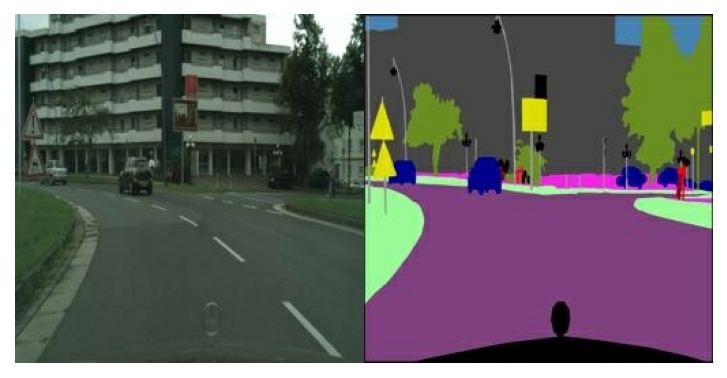

In [5]:
img = tf.io.read_file(train_fnames[0])  # Training sample
img = tf.io.decode_jpeg(img)    # A H, 2W, 3 image (2W because hstack)
# Show image
plt.figure(dpi=150)
plt.imshow(img)
plt.axis('off')
plt.show()

Convert an image (pair) to separate images

In [37]:
# Split image, return prediction, input images
def cut_image(img_fname: str):
    # Read and decode
    img = tf.io.decode_jpeg(tf.io.read_file(img_fname))
    # Split image (half width cut)
    w = img.shape[1]//2 # Cut point
    pred_img = img[:, :w]   # Prediction (first part)
    in_img = img[:, w:]     # Input image (second part)
    # Covert to float32
    pred_img = tf.cast(pred_img, tf.float32)
    in_img = tf.cast(in_img, tf.float32)
    return pred_img, in_img

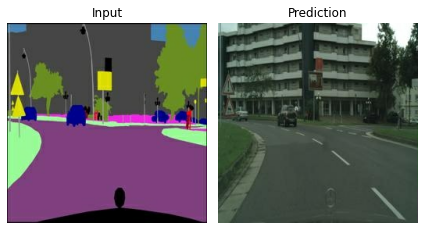

In [46]:
# View a separated image pair
pred_img, in_img = cut_image(train_fnames[0])
# Plot images
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(in_img/255)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Prediction") # To be generated
plt.imshow(pred_img/255)
plt.axis('off')
plt.tight_layout()
plt.show()

### Data Augmentation

Data augmentation defined in the paper to increase training data
